# Variational MPS and iTEBD for Three-body Spin Model

This notebook contains code for two different approaches to obtain ground state of a three-body spin model, namely:
1. variational matrix product state method (variational MPS),
2. infinite-time evolving block decimation method (iTEBD).

The model we are interested in is of the following Hamiltonian:
$$
H = -\sum_j (\sigma_{j-1}^z \sigma_{j}^x \sigma_{j+1}^z + \sigma_j^y).
$$
And we would like to investigate the ground state of this model on a $N=10$ lattice with open boundary condition using 2-site variational MPS method and on an infinite length lattice using 3-site iTEBD method.

# Variational MPS

Firstly, let's give variational MPS a try.

## MPO form of Hamiltonian

To implement variational MPS, we shall construct the matrix product operator (MPO) first.

The MPO for this model is
$$
M = \begin{pmatrix}
I &-\sigma^z &0 &-\sigma^y\\
0 &0 &\sigma^x &0\\
0 &0 &0 &\sigma^z\\
0 &0 &0 &I
\end{pmatrix}.
$$
Let's implement this.

In [1]:
import numpy as np
np.random.seed(42)

Sx = np.array([[0, 1], [1, 0]])
Sy = np.array([[0, -1j], [1j, 0]])
Sz = np.array([[1, 0], [0, -1]])
I = np.eye(2)

mpo = np.zeros((4, 2, 4, 2), dtype=complex)
mpo[0, :, 0, :] = I
mpo[0, :, 1, :] = -Sz
mpo[0, :, 3, :] = -Sy
mpo[1, :, 2, :] = Sx
mpo[2, :, 3, :] = Sz
mpo[3, :, 3, :] = I

## State Initialization

The second thing we shall do is to define a matrix product state and initialize it.

In [2]:
# import subroutines for tensor manipulation
import sys
sys.path.append("..")
from sample_code.vMPS_iTEBD import Sub180221 as Sub

def init_mps(n_site, dim_phys, dim_bond):
    mps = [None] * n_site
    for i in range(n_site):
        dim_left = min(dim_phys ** i, dim_phys ** (n_site - i), dim_bond)
        dim_right = min(dim_phys ** (i+1), dim_phys ** (n_site-1-i), dim_bond)
        mps[i] = np.random.rand(dim_left, dim_phys, dim_right)
    
    # canonicalize
    U = np.eye(np.shape(mps[-1])[-1])
    for i in range(n_site - 1, 0, -1):
        U, mps[i] = Sub.Mps_LQP(mps[i], U)
    
    return mps

## Environment Initialization

The third step is to multiply out all the MPOs and sandwitch it with the MPS to obtain the whole tensor.

This step is called environment initialization (i.e. all the tensors in $\bra{\psi}H\ket{\psi}$).

In [3]:
def initH(mpo, mps):
    n_site = len(mps)
    dim_mpo = np.shape(mpo)[0]
    
    H_left = [None] * n_site
    H_right = [None] * n_site
    
    H_left[0] = np.zeros((1, dim_mpo, 1))
    H_left[0][0, 0, 0] = 1
    H_right[-1] = np.zeros((1, dim_mpo, 1))
    H_right[-1][0, -1, 0] = 1
    
    for i in range(n_site - 1, 0, -1):
        H_right[i - 1] = Sub.NCon([H_right[i], mps[i], mpo, np.conj(mps[i])], 
        [[1, 3, 5], [-1, 2, 1], [-2, 2, 3, 4], [-3, 4, 5]])
    
    return H_left, H_right

## Site Update

The final step is to update each two site in an iterative manner and obtain the ground state in covergence.

We implement the two site update precedure first and then carry out the sweeping.

For the two site update precedure, we can generalize it to **arbitrary n sites** update precedure as below.

In [4]:
import scipy.sparse.linalg as LAs

def update_sites(mpo, H_left, H_right, site_tensor_list, reverse=False):
    '''
    Update arbitrary n consecutive sites in the MPS
    '''
    shape_site_tensor_list = list(map(np.shape, site_tensor_list))
    dim_site_tensor_list = list(map(lambda x: x[1], shape_site_tensor_list))
    n_sites = len(shape_site_tensor_list)
    
    # contract and minimize energy
    contract_rule = [[-1, 1, -(n_sites + 3)]] + \
                    [[i, -(n_sites + 3 + i), i + 1, -(1 + i)] for i in range(1, n_sites + 1)] + \
                    [[-(2 * n_sites + 4), n_sites + 1, -(n_sites + 2)]]
    H_eff = Sub.NCon([H_left] + [mpo] * n_sites + [H_right], contract_rule)
    H_eff = Sub.Group(H_eff, [[i for i in range(n_sites + 2)], [i for i in range(n_sites + 2, 2 * n_sites + 4)]])
    eigval, eigvec = LAs.eigsh(H_eff, k=1, which='SA')

    # update tensor
    if not reverse:
        # left to right
        updated_site_tensor = np.reshape(eigvec, [H_left.shape[-1]] + dim_site_tensor_list + [H_right.shape[0]])
        updated_site_tensor_list = [None] * n_sites
        for i in range(n_sites - 1):
            svd_tensor = Sub.Group(updated_site_tensor, [[0, 1], list(range(2, len(updated_site_tensor.shape)))])
            u, s, v = np.linalg.svd(svd_tensor, full_matrices=False)
            dim_trunc = min(len(s), shape_site_tensor_list[i][-1])
            u = u[:, :dim_trunc]; s = s[:dim_trunc]; v = v[:dim_trunc, :]
            updated_site_tensor_list[i] = u.reshape(shape_site_tensor_list[i])
            updated_site_tensor = np.diag(s) @ v
        updated_site_tensor_list[-1] = updated_site_tensor.reshape(shape_site_tensor_list[-1])
    else:
        # right to left
        updated_site_tensor = np.reshape(eigvec, [H_left.shape[0]] + dim_site_tensor_list + [H_right.shape[-1]])
        updated_site_tensor_list = [None] * n_sites
        for i in range(n_sites - 1, 0, -1):
            svd_tensor = Sub.Group(updated_site_tensor, [list(range(len(updated_site_tensor.shape) - 2)), [len(updated_site_tensor.shape) - 2, len(updated_site_tensor.shape) - 1]])
            u, s, v = np.linalg.svd(svd_tensor, full_matrices=False)
            dim_trunc = min(len(s), shape_site_tensor_list[i][0])
            u = u[:, :dim_trunc]; s = s[:dim_trunc]; v = v[:dim_trunc, :]
            updated_site_tensor_list[i] = v.reshape(shape_site_tensor_list[i])
            updated_site_tensor = u @ np.diag(s)
        updated_site_tensor_list[0] = updated_site_tensor.reshape(shape_site_tensor_list[0])
    
    return updated_site_tensor_list, eigval

Now we can implement the sweeping precedure.

Here we update two sites per step.

In [5]:
def sweep(n_iter, mpo, H_left, H_right, mps):
    n_sites = len(mps)
    eig0 = np.zeros(n_sites)
    eig1 = np.zeros(n_sites)
    
    for r in range(n_iter):
        print(f'Iteration {r}:')
    
        for i in range(n_sites - 1):
            mps[i:i+2], eig1[i] = update_sites(mpo, H_left[i], H_right[i+1], mps[i:i+2], reverse=False)
            mps[i], U = Sub.Mps_QR0P(mps[i])
            H_left[i+1] = Sub.NCon([H_left[i], np.conj(mps[i]), mpo, mps[i]], 
                            [[1, 3, 5], [1, 2, -1], [3, 4, -2, 2], [5, 4, -3]])
            mps[i+1] = np.tensordot(U, mps[i+1], (1, 0))
        
        for i in range(n_sites - 1, 1, -1):
            mps[i-1:i+1], eig1[i] = update_sites(mpo, H_left[i-1], H_right[i], mps[i-1:i+1], reverse=True)
            U, mps[i] = Sub.Mps_LQ0P(mps[i])
            H_right[i-1] = Sub.NCon([H_right[i], mps[i], mpo, np.conj(mps[i])], 
                            [[1, 3, 5], [-1, 2, 1], [-2, 2, 3, 4], [-3, 4, 5]])
            mps[i-1] = np.tensordot(mps[i-1], U, (2,0))
        
        print(eig1)
        if (abs(eig1 - eig0) < 1.0e-7).all():
            break
        eig0 = eig1.copy()
    
    print(f'energy per site: {eig1/n_sites}')

    return mps

## Demo

Now let's demonstrate this approach by calculating the ground state energy, magnetization $\langle \sigma^z_i\rangle$ and $\langle \sigma^x_i\rangle$ on our model.

We choose `dim_bond = 4, 6`.

In [10]:
for dim_bond in [4, 6]:
    print(f'dim_bond = {dim_bond}:\n' + '#'*50)
    n_sites = 10; dim_phys = 2
    mpo = mpo
    mps = init_mps(n_sites, dim_phys, dim_bond)
    H_left, H_right = initH(mpo, mps)
    mps = sweep(100, mpo, H_left, H_right, mps)

    # transfer matrix
    transfer_matrix = [None] * n_sites
    transfer_matrix_sz = [None] * n_sites
    transfer_matrix_sx = [None] * n_sites
    for i in range(n_sites):
        transfer_matrix[i] = Sub.Group(Sub.NCon([mps[i], np.conj(mps[i])], [[-1, 1, -2], [-3, 1, -4]]), [[0, 2], [1, 3]])
        transfer_matrix_sz[i] = Sub.Group(Sub.NCon([mps[i], Sz, np.conj(mps[i])], [[-1, 1, -2], [1, 2], [-3, 2, -4]]), [[0, 2], [1, 3]])
        transfer_matrix_sx[i] = Sub.Group(Sub.NCon([mps[i], Sx, np.conj(mps[i])], [[-1, 1, -2], [1, 2], [-3, 2, -4]]), [[0, 2], [1, 3]])

    # calculate observables
    sz = np.zeros(n_sites)
    sx = np.zeros(n_sites)
    for i in range(n_sites):
        transfer_matrix_list = transfer_matrix.copy()
        transfer_matrix_list[i] = transfer_matrix_sz[i]
        sz[i] = np.real(Sub.NCon(transfer_matrix_list, [[-1, 1]] + [[i+1, i+2] for i in range(n_sites-2)] + [[n_sites-1, -2]]).trace())
        transfer_matrix_list = transfer_matrix.copy()
        transfer_matrix_list[i] = transfer_matrix_sx[i]
        sx[i] = np.real(Sub.NCon(transfer_matrix_list, [[-1, 1]] + [[i+1, i+2] for i in range(n_sites-2)] + [[n_sites-1, -2]]).trace())

    print(f'<s^z_i> = {sz}')
    print(f'<s^x_i> = {sx}')


dim_bond = 4:
##################################################
Iteration 0:
[ -4.3890553   -5.75833775 -11.48598779 -11.48640511 -11.4844772
 -11.48288606 -11.48038403 -11.48003578 -11.47964578 -11.47964578]
Iteration 1:
[-11.48598779 -11.48598779 -11.48597512 -11.48639428 -11.48660148
 -11.48666675 -11.48660252 -11.48639585 -11.48597677 -11.48597677]
Iteration 2:
[-11.48597512 -11.48597512 -11.48597502 -11.4863942  -11.48660113
 -11.48666585 -11.48660113 -11.4863942  -11.48597503 -11.48597503]
Iteration 3:
[-11.48597502 -11.48597502 -11.48597502 -11.4863942  -11.48660113
 -11.48666585 -11.48660113 -11.4863942  -11.48597502 -11.48597502]
energy per site: [-1.1485975  -1.1485975  -1.1485975  -1.14863942 -1.14866011 -1.14866659
 -1.14866011 -1.14863942 -1.1485975  -1.1485975 ]
<s^z_i> = [-7.78071233e-11  7.25546286e-11  1.37940177e-11 -9.45918225e-11
  6.97469096e-11  4.33071853e-12 -1.12491703e-10  1.45920104e-10
  4.63734552e-11 -3.95139947e-10]
<s^x_i> = [ 6.80138801e-16  1.81296226

## Compare with Exact Diagonalization

We can further compare our results with exact diagonalization.

We borrow code from `task1`.

Note that it's open boundary condition!

In [14]:
def readBit(num, n):
    return (num & (1 << n)) >> n

def flipBit(num, n):
    return num ^ (1 << n)

from scipy import sparse

N = 10
length = 2 ** N

# Hamiltonian
HFrom = []
HTo = []
HValue = []

print('Exact Diagonalization:')

for fromBasis in range(length):

    for i in range(N):
        HFrom.append(fromBasis)
        HTo.append(flipBit(fromBasis, i))
        if i == 0 or i == N-1: # open boundary condition
            HValue.append(- (1 - 2*readBit(fromBasis, i))*1j)
        else:
            HValue.append(-(1 - 2*readBit(fromBasis, (i-1)%N)) * (1 - 2*readBit(fromBasis, (i+1)%N)) - (1 - 2*readBit(fromBasis, i))*1j)

Hed = sparse.coo_matrix((HValue, (HTo, HFrom)), shape=(length, length)).toarray()
eigval, eigvec = LAs.eigsh(Hed, k=1, which='SA')
print(f'Energy: {eigval}, Energy per site: {eigval/N}')

Exact Diagonalization:
Energy: [-11.48944207], Energy per site: [-1.14894421]


The ground state energies only differs by $10^{-4}$!

# iTEBD

Now we turn to the infinite-time evolving block decimation method.

We choose `dim_bond = 6` and calculate the ground state energy per site using a 3 site-version.

Furthermore, we would like to investigate the entanglement entropy and entanglement spectrum.

## Hamiltonian and State Initialization

Similar to the vMPS method above, we shall first construct the Hamiltonian and initialize the state.

Due to translational symmetry, we only need the local three body Hamiltonian, which is quite simple:
$$
h_i = -(\sigma^z_{i-1}\sigma^x_{i}\sigma^z_{i+1}+\sigma^y_{i}).
$$

As for the matrix product state, we use SVD to canonicalize it (i.e. factorize each site tensor into -T-G-, where G is a diagonal matrix).


In [15]:
# Hamiltonian
h = -(np.kron(Sz, np.kron(Sx, Sz)) + np.kron(I, np.kron(Sy, I)))
h = np.reshape(h, (2, 2, 2, 2, 2, 2))

# initialize state
def init_mps_TG(dim_phys, dim_bond, n_sites):
    Ts = [None] * n_sites
    Gs = [None] * n_sites
    
    for i in range(n_sites):
        Ts[i] = np.random.rand(dim_bond, dim_phys, dim_bond)
        Gs[i] = np.random.rand(dim_bond)

    return Ts,Gs

## Evolution

To implement iTEBD, we need to exponentiate the Hamiltonian, (i.e. imaginary time evolution):
$$
U_i = e^{-\tau h_i}.
$$

In [16]:
def exp_h(h, tau):
    dim_phys = np.shape(h)[0]
    if np.linalg.norm(h) < 1e-12:
        return np.reshape(np.eye(dim_phys ** 3),
         [dim_phys, dim_phys, dim_phys, dim_phys, dim_phys, dim_phys])
    else:
        matrix = np.reshape(h, [dim_phys**3, dim_phys**3])
        eigvals, eigvecs = np.linalg.eigh(matrix)
        matrix_exp = eigvecs @ np.diag(np.exp(- tau * eigvals)) @ np.conjugate(eigvecs.T)
        return np.reshape(matrix_exp, [dim_phys, dim_phys, dim_phys, dim_phys, dim_phys, dim_phys])


Now we turn to the update precedure.

We implement first the three-site (two-bond) update precedure, then the whole sweeping.

In [17]:
def evolve_two_bond(Gl, T1, G1, T2, G2, T3, Gr, dim_bond, U):
    whole_tensor = Sub.NCon(
        [np.diag(Gl), T1, np.diag(G1), T2, np.diag(G2), T3, np.diag(Gr), U],
        [[-1, 1], [1, 7, 2], [2, 3], [3, 8, 4], [4, 5], [5, 9, 6], [6, -5], [-2, -3, -4, 7, 8, 9]]
    )
    shape_whole = np.shape(whole_tensor)
    tensor_svd = Sub.Group(whole_tensor, [[0, 1], [2, 3, 4]])
    
    # T1, G1
    U1, G1_update, V1 = np.linalg.svd(tensor_svd, full_matrices=False)
    dim_trunc = min(len(G1_update), dim_bond)
    U1 = U1[:, :dim_trunc]; G1_update = G1_update[:dim_trunc]; V1 = V1[:dim_trunc, :]
    G1_update /= np.sqrt(np.sum(G1_update ** 2))
    T1_update = np.tensordot(np.diag(1/Gl), np.reshape(U1, [shape_whole[0], shape_whole[1], dim_trunc]), (1, 0))

    # T2, G2
    U2, G2_update, V2 = np.linalg.svd(np.reshape(V1, [dim_bond * shape_whole[2], -1]), full_matrices=False)
    dim_trunc = min(len(G2_update), dim_bond)
    U2 = U2[:, :dim_trunc]; G2_update = G2_update[:dim_trunc]; V2 = V2[:dim_trunc, :]
    G2_update /= np.sqrt(np.sum(G2_update ** 2))
    T2_update = np.reshape(U2, [-1, shape_whole[3], dim_trunc])

    # T3
    T3_update = np.tensordot(np.reshape(V2, [dim_trunc, shape_whole[3], shape_whole[4]]), np.diag(1/Gr), (2, 0))

    return T1_update, G1_update, T2_update, G2_update, T3_update


Then the sweeping precedure.

In [18]:
def evolve(Ts, Gs, h, n_iter, tau_list, prec_list, dim_bond, adaptive_tau=False):
    errs = []
    Gs_last = np.ones(3)
    Gs_diff_last = np.zeros_like(Gs_last)
    n_nondecrease = 0
    for tau, prec in zip(tau_list, prec_list):
        tau_init = tau
        U = exp_h(h, tau)
        for i in range(n_iter):
            for bond in range(3):
                Ts[bond], Gs[bond], Ts[(bond+1)%3], Gs[(bond+1)%3], Ts[(bond+2)%3] = evolve_two_bond(
                    Gs[(bond-1)%3], Ts[bond], Gs[bond], Ts[(bond+1)%3], Gs[(bond+1)%3], Ts[(bond+2)%3], Gs[(bond+2)%3], dim_bond, U
                )
            
            Gs_diff = np.sum(np.abs(Gs_last - np.array(Gs)[:, 0]))
            if (Gs_diff >= Gs_diff_last).any():
                n_nondecrease += 1
            else:
                n_nondecrease = 0

            if Gs_diff < prec:
                print(f'tau {tau}, precision {prec}, converged at iteration {i}')
                break
            
            Gs_last = np.array(Gs)[:, 0].copy()
            Gs_diff_last = Gs_diff.copy()
            errs.append(Gs_diff)

            # adaptive tau
            if adaptive_tau and n_nondecrease == n_iter/10 and tau >= tau_init[-1]/10:
                n_nondecrease = 0
                tau /= 2
                U = exp_h(h, tau)

    return Ts, Gs, errs

## Demo

Now that we have all the ingredients of iTEBD, we can run a demo.

In [19]:
dim_bond = 6
h = h
Ts, Gs = init_mps_TG(2, dim_bond, 3)
Ts, Gs, errs = evolve(Ts, Gs, h, 100000, [0.1, 0.01, 0.001], [1e-6, 1e-8, 1e-10], dim_bond)

tau 0.1, precision 1e-06, converged at iteration 3562


## Analysis of Error Dynamic

Note that the `1e-10` convergence is quite hard to achieve.

From the error dynamic we can see that the error experience some kind of period, which might comes from a too large choice of tau, causing it jumping around the minimum.

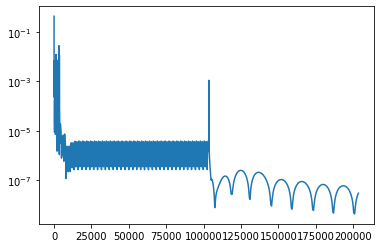

In [20]:
import matplotlib.pyplot as plt
plt.plot(errs[:])
plt.yscale('log')
plt.show()

Therefore, we develope an adaptive tau method to incrementally tune down tau in the progress of optimizing.

In [21]:
Tsa, Gsa, errsa = evolve(Ts, Gs, h, 100000, [0.1, 0.01, 0.001], [1e-6, 1e-8, 1e-10], dim_bond, adaptive_tau=True)

tau 0.1, precision 1e-06, converged at iteration 703
tau 0.01, precision 1e-08, converged at iteration 4627
tau 0.001, precision 1e-10, converged at iteration 52179


The adaptive method reaches convergence a lot faster.

From the figure below, we can also see that the error experiences a much cleaner dynamic and drops a lot faster.

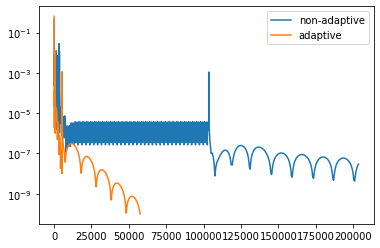

In [22]:
import matplotlib.pyplot as plt
plt.plot(errs[:], label='non-adaptive')
plt.plot(errsa[:], label='adaptive')
plt.yscale('log')
plt.legend()
plt.show()

## Energy and Entanglement

Now we can calculate the energy and entanglement spectrum of the ground state.

In [23]:
def obs_two_bond(obs, Gl, T1, G1, T2, G2, T3, Gr):
    state = Sub.NCon([np.diag(Gl), T1, np.diag(G1), T2, np.diag(G2), T3, np.diag(Gr)],
    [[-1, 1],[1, -2, 2], [2, 3], [3, -3, 4], [4, 5], [5, -4, 6], [6, -5]])
    val = Sub.NCon([state, obs, np.conj(state)],
    [[7, 1, 2, 3, 8], [4, 5, 6, 1, 2, 3], [7, 4, 5, 6, 8]])
    return val

def cal_energy(Ts, Gs, h):
    dim_phys = np.shape(h)[0]
    
    normalize_obs = np.reshape(np.eye(dim_phys**3, dim_phys**3),
            [dim_phys, dim_phys, dim_phys, dim_phys, dim_phys, dim_phys])
    
    normalize = np.zeros(3)
    energy = np.zeros(3)
    
    for bond in range(3):
        normalize[bond] = np.real(obs_two_bond(normalize_obs, Gs[(bond-1)%3], Ts[bond], Gs[bond], Ts[(bond+1)%3], Gs[(bond+1)%3], Ts[(bond+2)%3], Gs[(bond+2)%3]))
        energy[bond] = np.real(obs_two_bond(h, Gs[(bond-1)%3], Ts[bond], Gs[bond], Ts[(bond+1)%3], Gs[(bond+1)%3], Ts[(bond+2)%3], Gs[(bond+2)%3]))
        energy[bond] /= normalize[bond]
        print(f'bond {bond}, normalize {normalize[bond]}, energy {energy[bond]}')
    
    energy = np.mean(energy)
    print(f'average energy per site: {energy}')
    
    return energy

def cal_entropy(Ts, Gs):
    entropy = np.zeros(3)
    for bond in range(len(Gs)):
        entropy[bond] = -np.sum((Gs[bond]**2) * np.log((Gs[bond]**2)))
        print(f'bond {bond}, entanglement entopy {entropy[bond]}, spectrum: {Gs[bond]**2}')
    
    entropy = np.mean(entropy)
    print(f'average entanglement entropy: {entropy}')
    return entropy


In [24]:
energy = cal_energy(Tsa, Gsa, h)
entropy = cal_entropy(Tsa, Gsa)

bond 0, normalize 0.1666666911998457, energy -1.185486419333206
bond 1, normalize 0.16663624173727898, energy -1.1317914584064541
bond 2, normalize 0.16666668327727988, energy -1.211890790045539
average energy per site: -1.1763895559283997
bond 0, entanglement entopy 1.536167221562223, spectrum: [0.31769044 0.25816965 0.23354059 0.093457   0.08599854 0.01114377]
bond 1, entanglement entopy 0.6723131348723925, spectrum: [0.81651933 0.08500868 0.06951662 0.02674243 0.00113136 0.00108158]
bond 2, entanglement entopy 0.6840606887537878, spectrum: [8.12677744e-01 9.47911191e-02 5.47389489e-02 3.56655411e-02
 1.63209541e-03 4.94551799e-04]
average entanglement entropy: 0.9641803483961345
